[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv5 on Custom Objects

**⚠️ This notebook was updated on October 24th, 2023. Since then, the way to load data into the notebook has changed. Thus, this notebook is not the same as the original version used in the accompanying YouTube video or blog post.**

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference

Let's get started!

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16567, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 16567 (delta 23), reused 31 (delta 13), pack-reused 16522
Receiving objects: 100% (16567/16567), 15.08 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (11380/11380), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:00
Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


## Step 6: Download a Dataset

Add your Roboflow API key below to download the default money counting dataset. Alternatively, use the code provided by the Roboflow dashboard in the above step to load a custom dataset.

In [ ]:
!pip install -q roboflow

#!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BMWLxCMxFPAks4AmkTSD")
project = rf.workspace("jose-castillo").project("project-pocket-paramedic")
version = project.version(1)
dataset = version.download("yolov5")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Project-Pocket-Paramedic-1 in yolov5pytorch:: 100%|██████████| 1928/1928 [00:00<00:00, 5467.10it/s]


In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

cat: {dataset.location}/data.yaml: No such file or directory


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
#!python train.py --img 416 --batch 16 --epochs 200 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 1.94 ms


# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

FileNotFoundError: [Errno 2] No such file or directory: '/content/yolov5/runs/train/yolov5s_results/results.png'

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

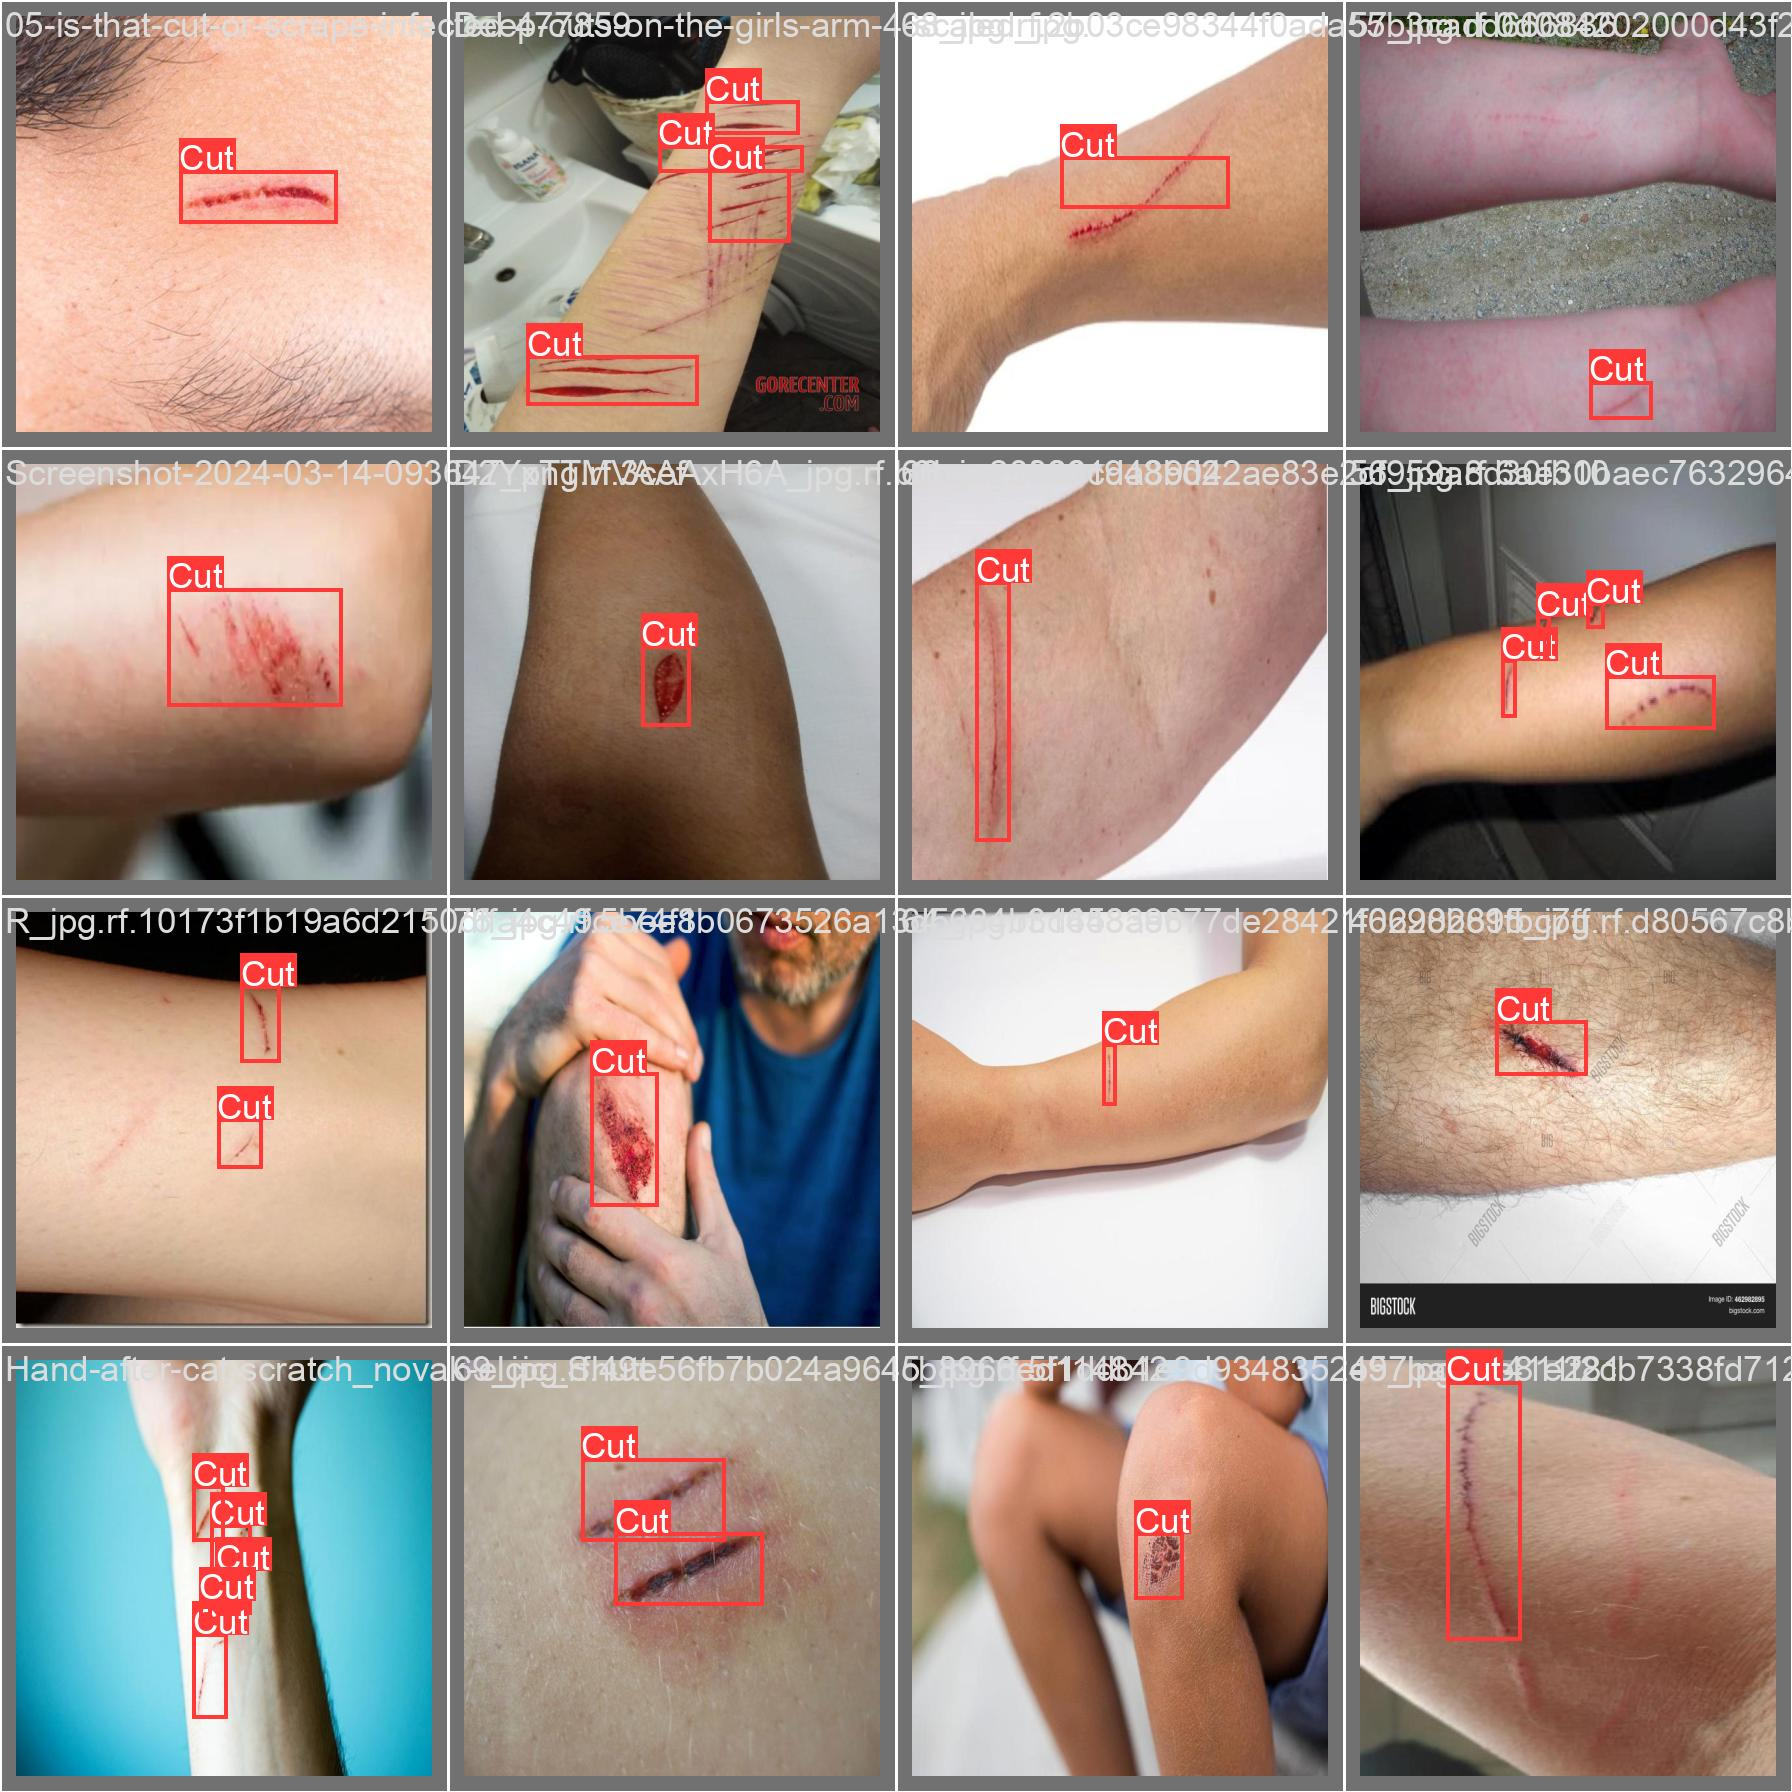

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


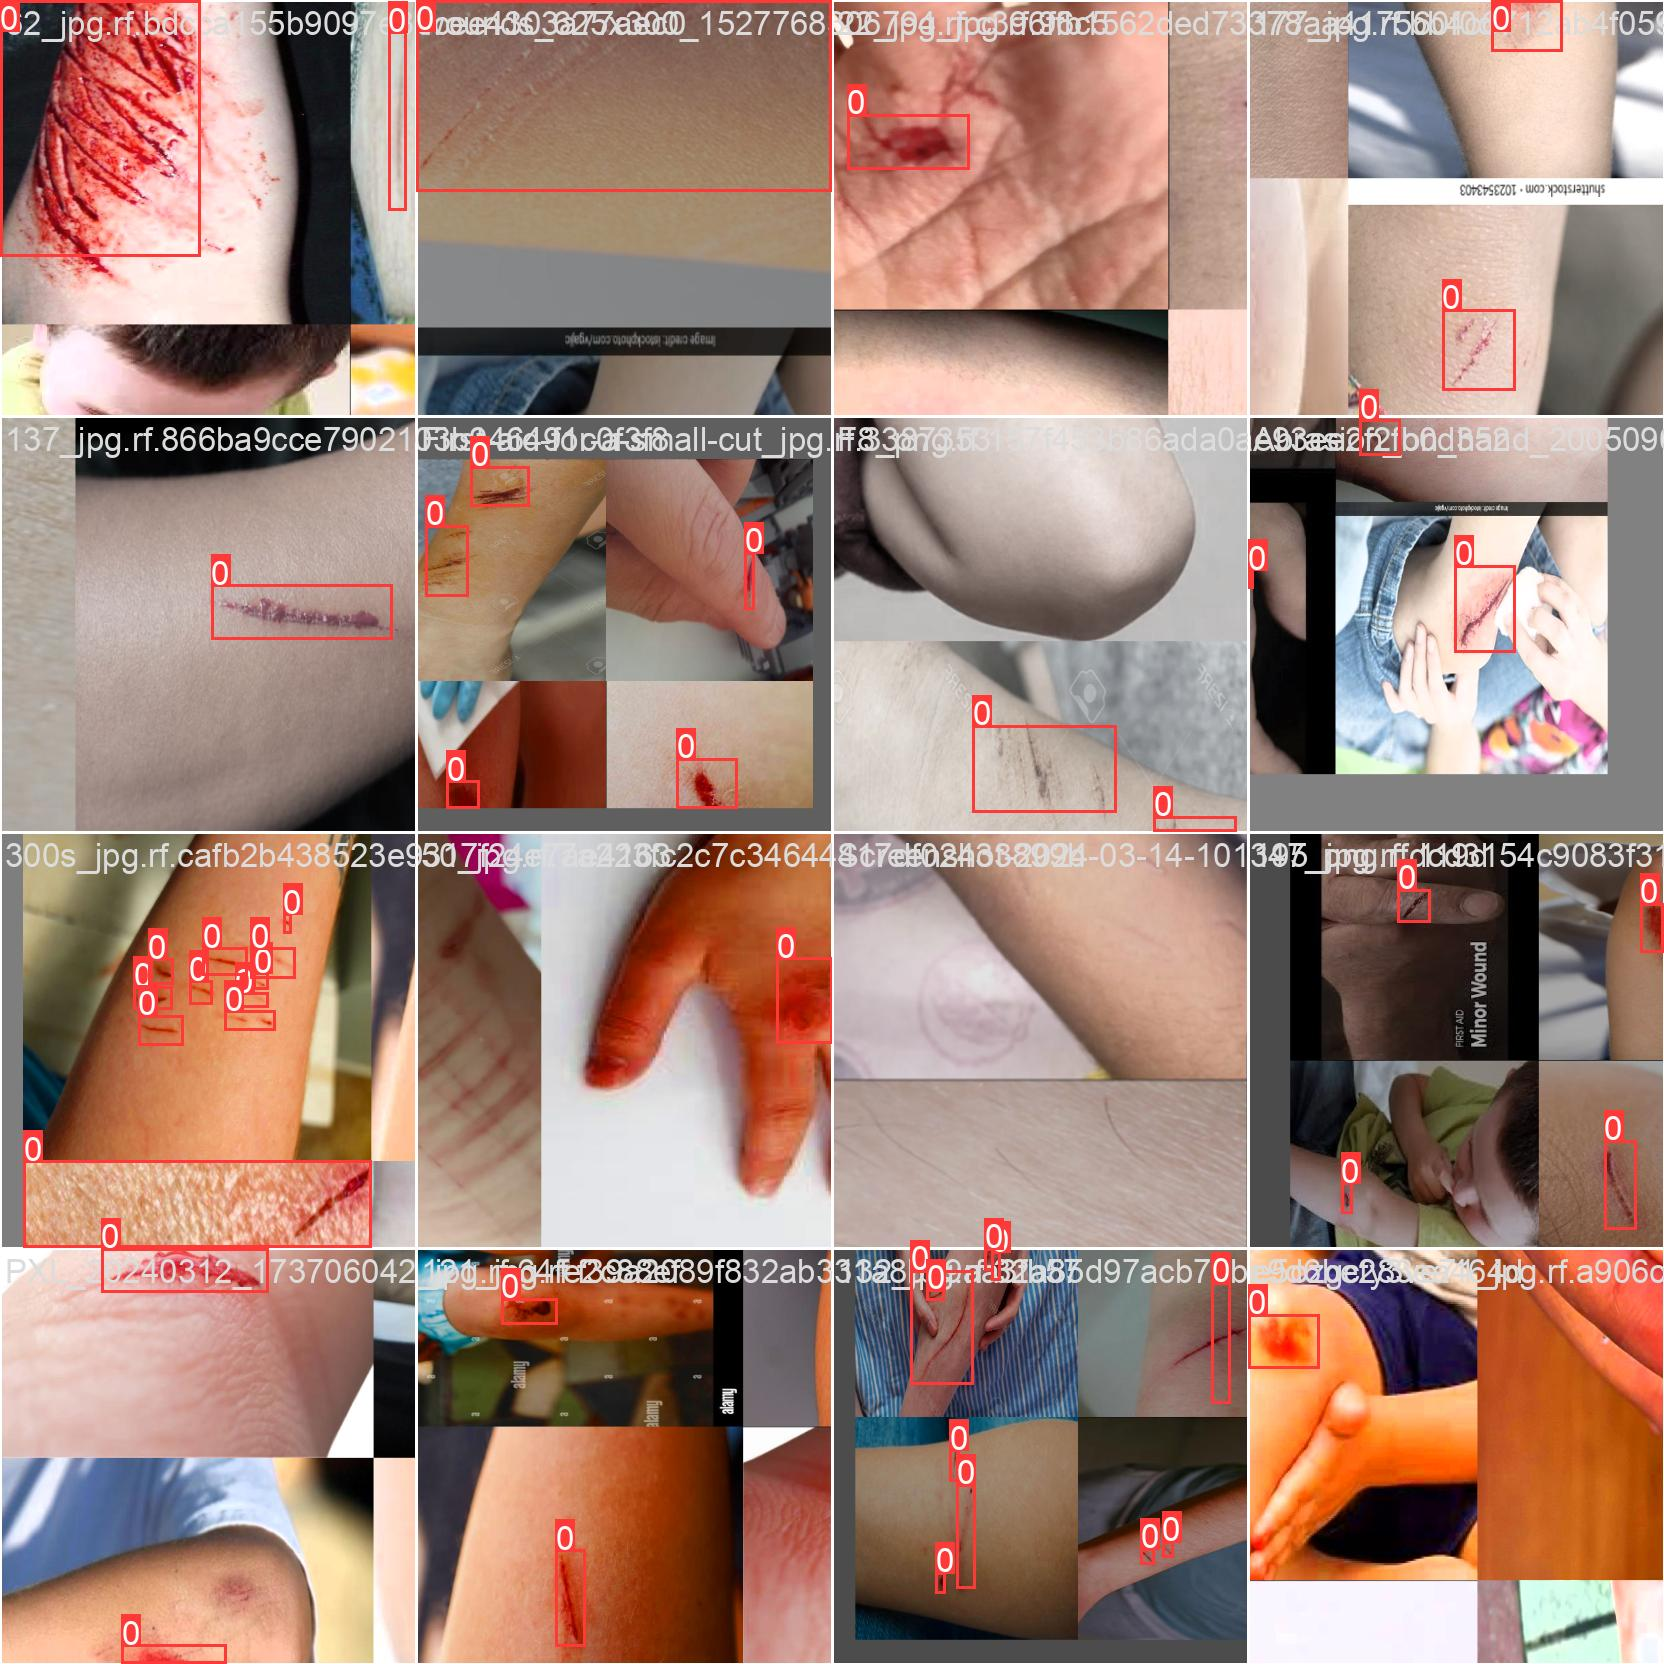

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

detect/  train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt  OLDbest.pt


In [ ]:
!pip list


Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In the snippet below, replace `Cash-Counter-10` with the name of the folder in which your dataset is stored.

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.25 --source Project-Pocket-Paramedic-1/test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=Project-Pocket-Paramedic-1/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
image 1/38 /content/yolov5/Project-Pocket-Paramedic-1/test/images/105_jpg.rf.1f65386579135eded6078f759b84b5eb.jpg: 416x416 3 Cuts, 7.7ms
image 2/38 /content/yolov5/Project-Pocket-Paramedic-1/test/images/109_jpg.rf.17e1a314b4b554c58fbf77ff7e0c352e.jpg: 416x416 1 Cut, 7.8ms
image 3/38 /content/yolov5/Pr

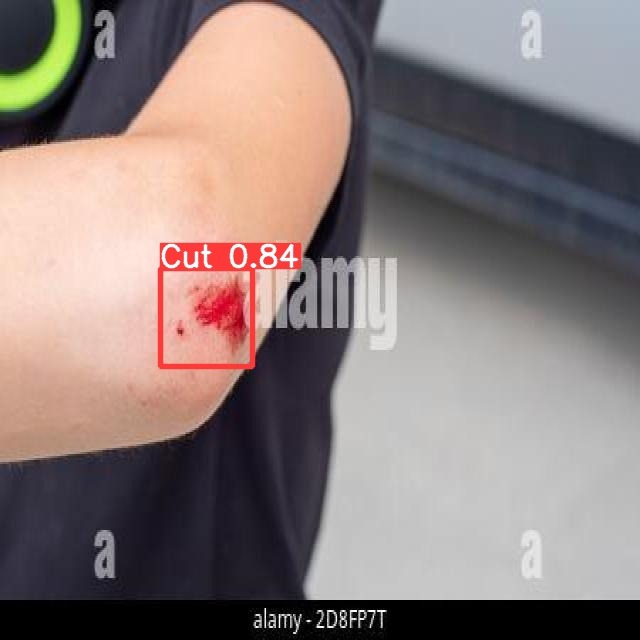

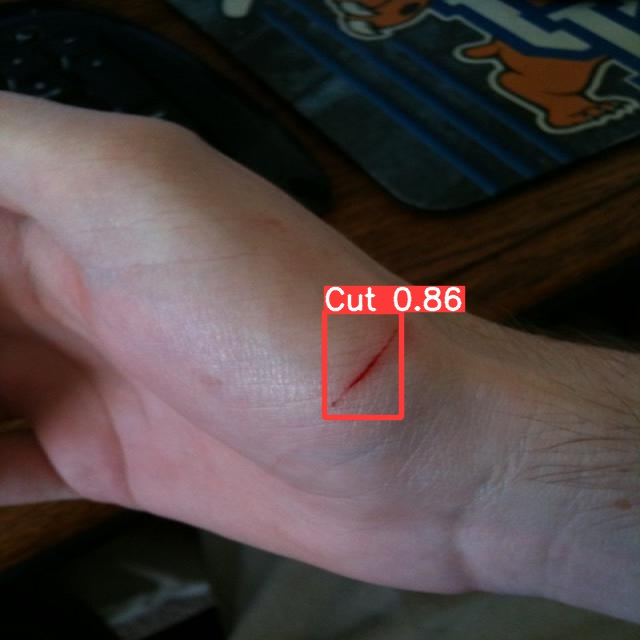

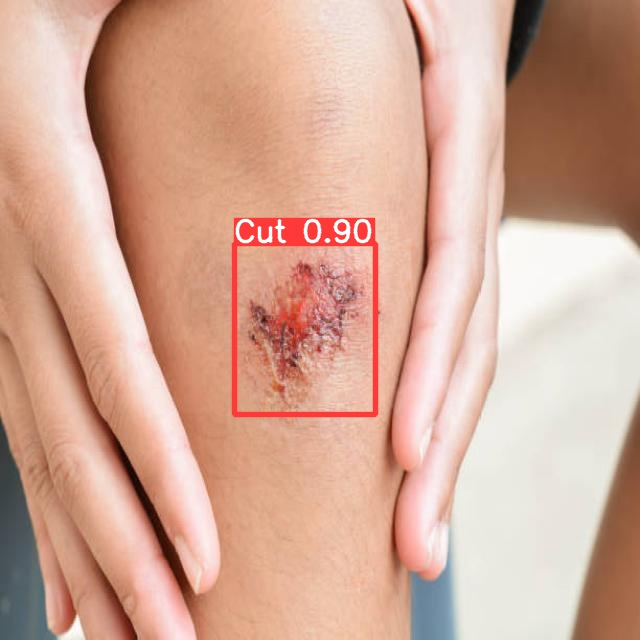

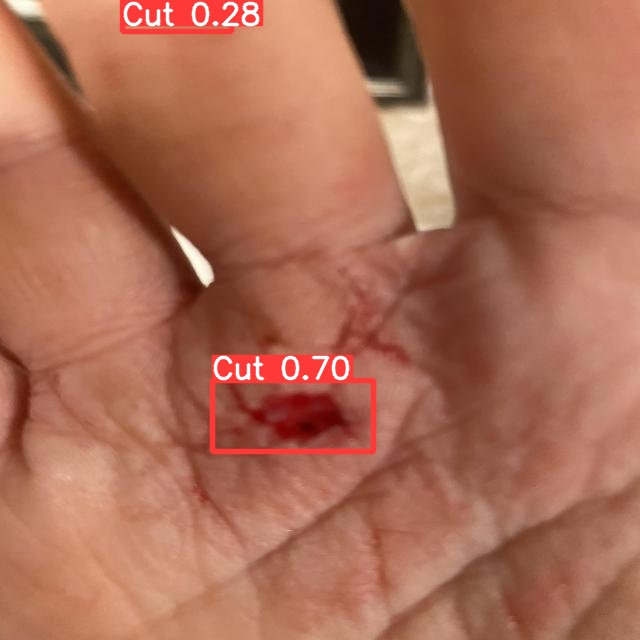

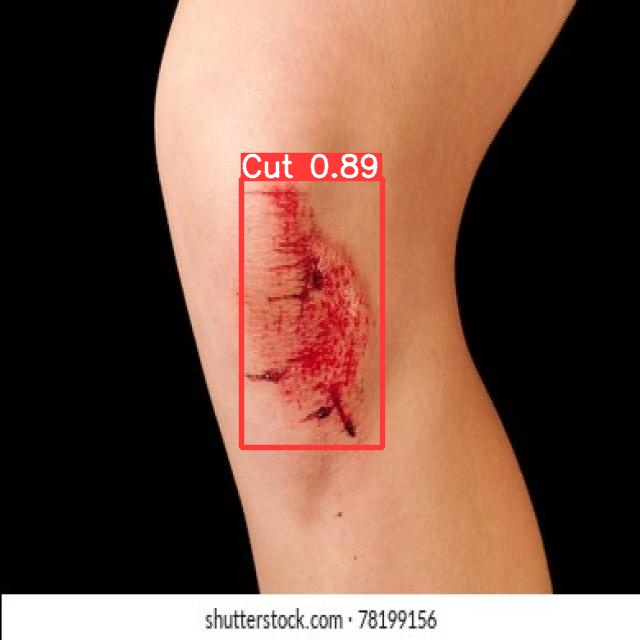

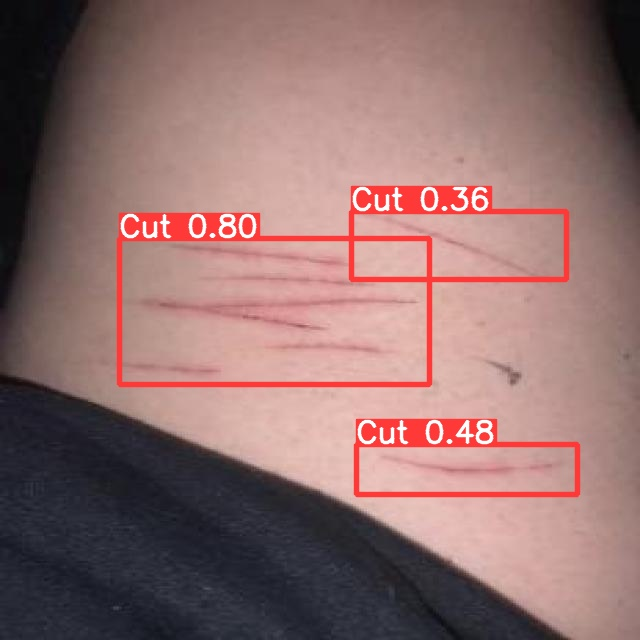

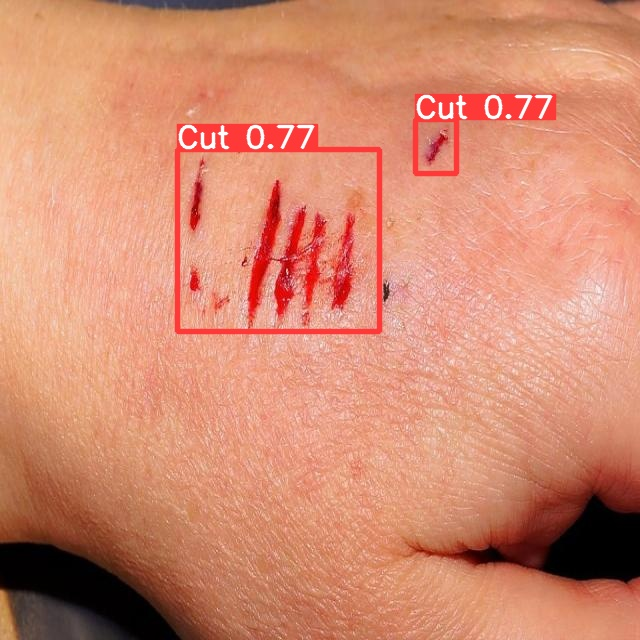

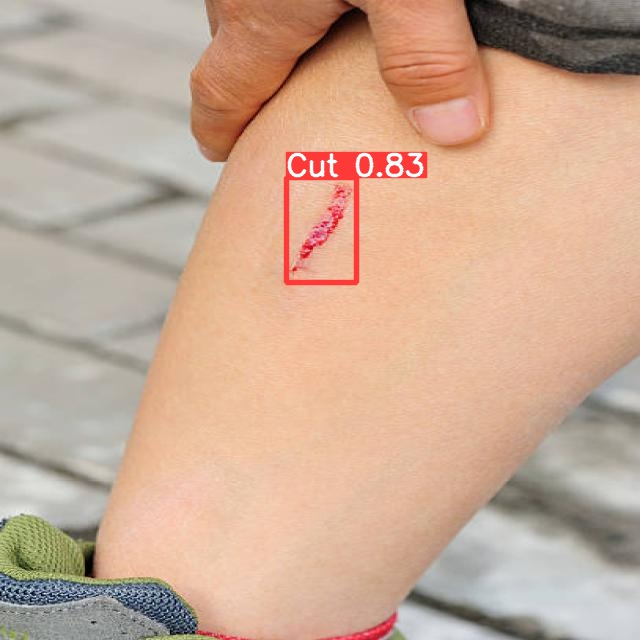

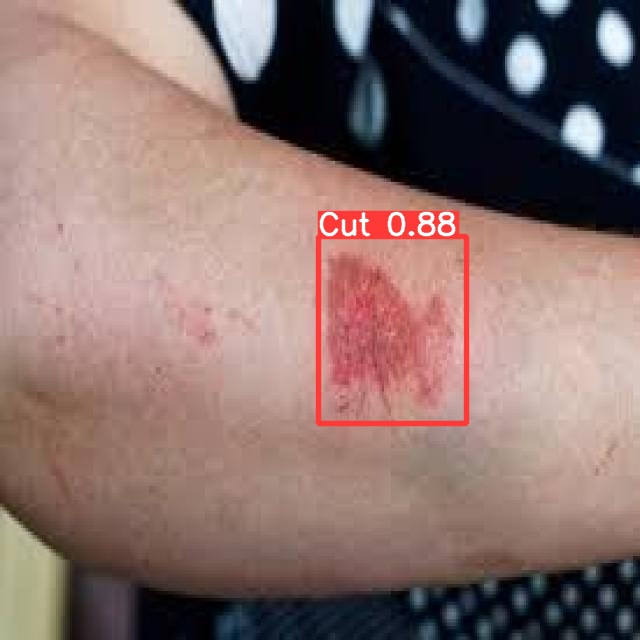

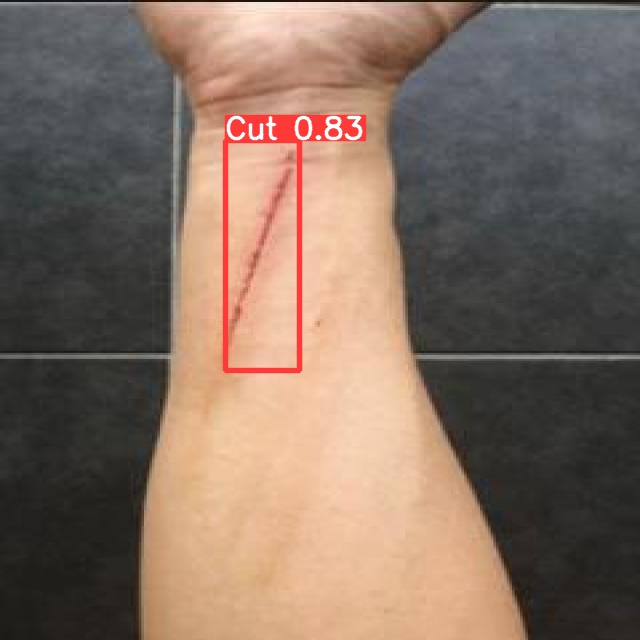

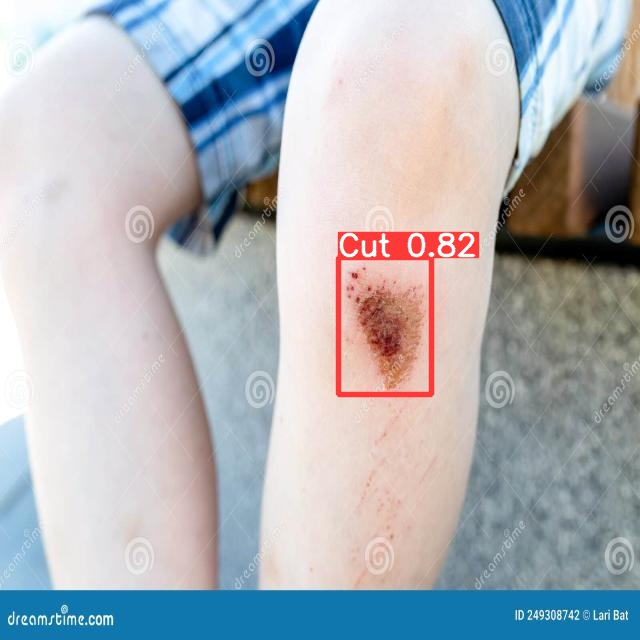

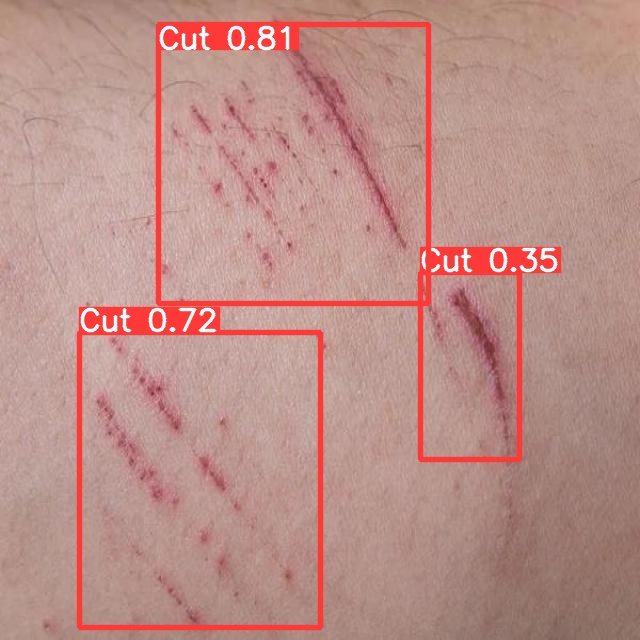

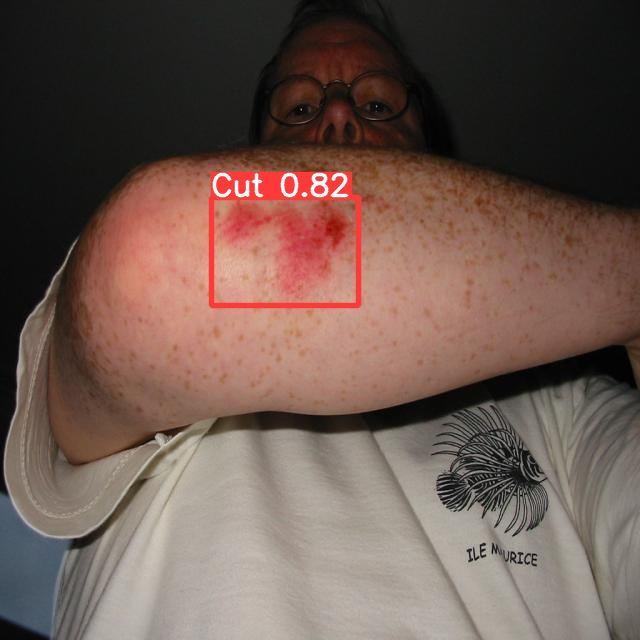

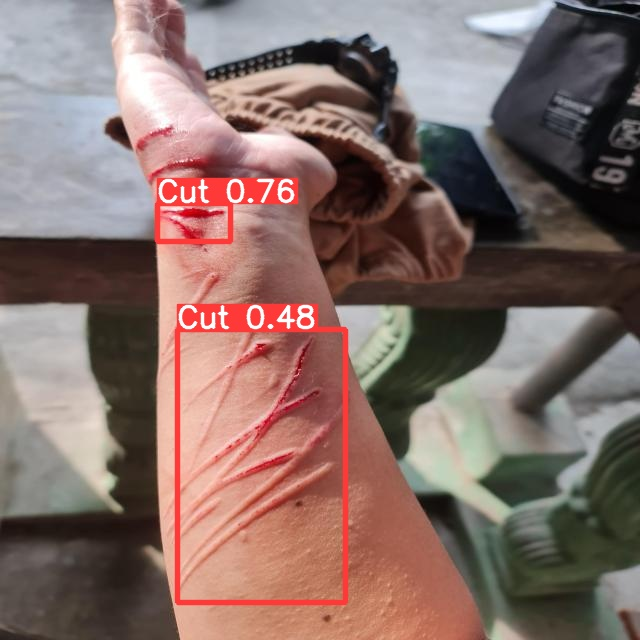

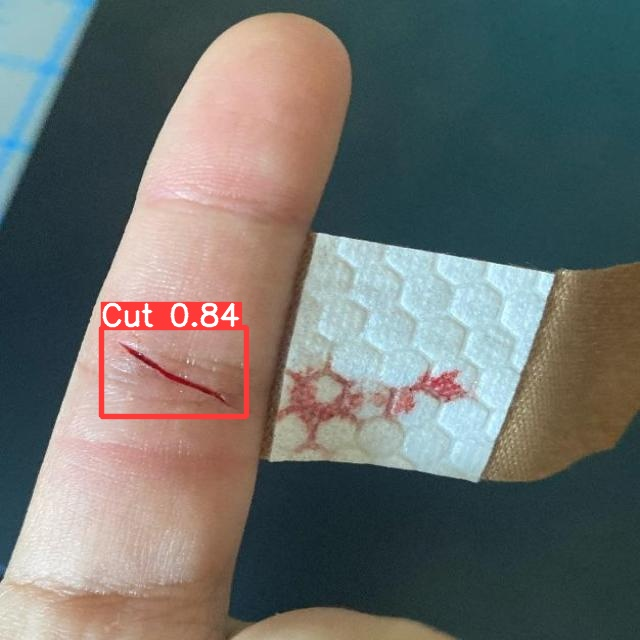

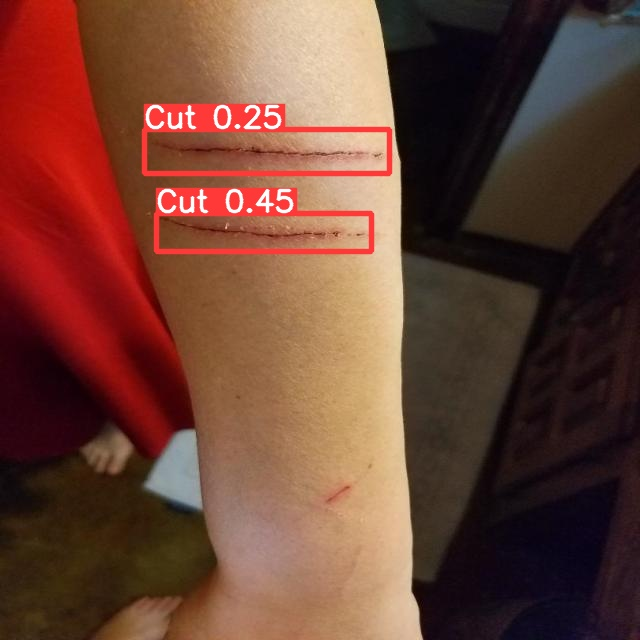

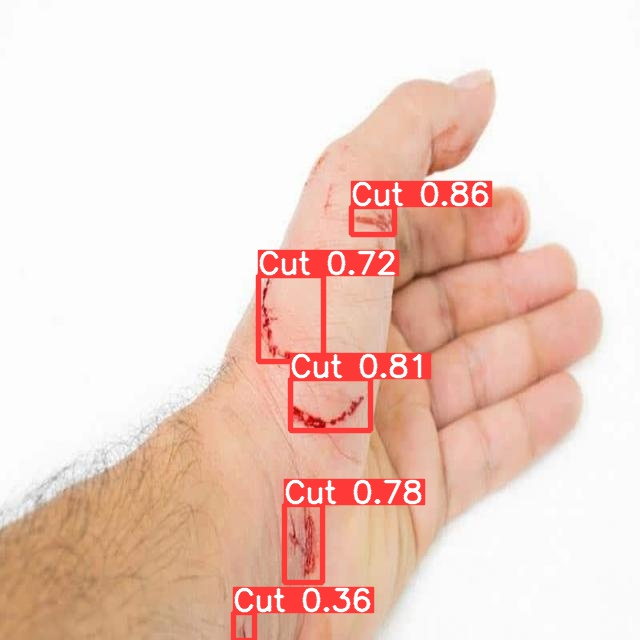

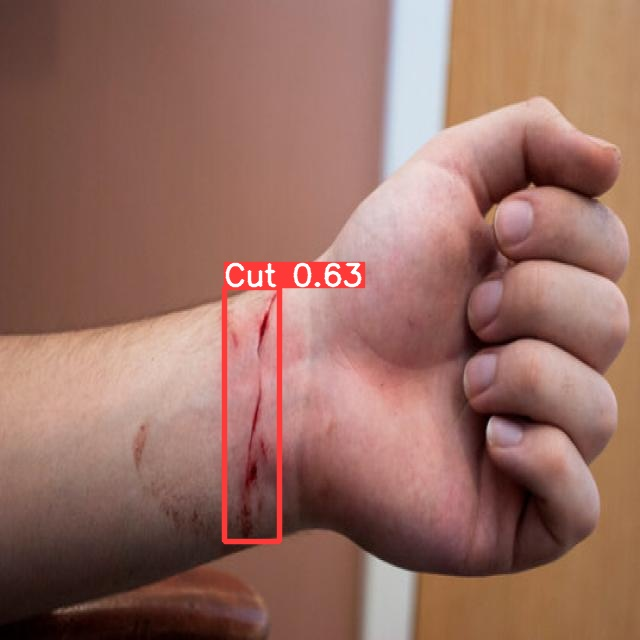

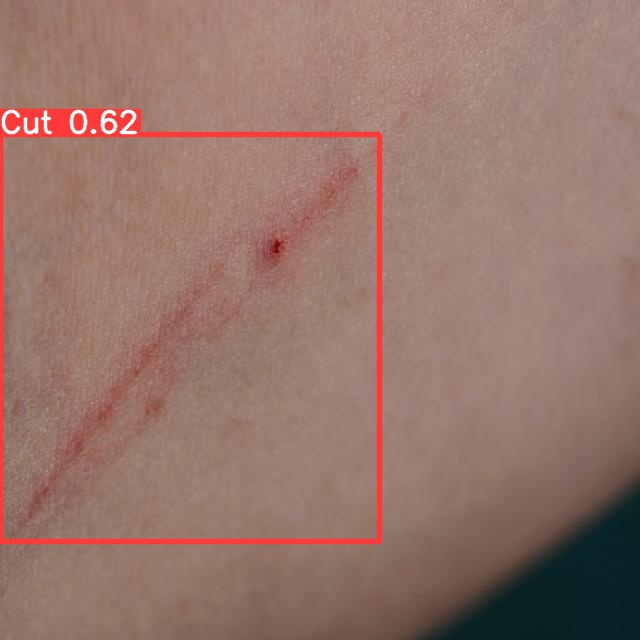

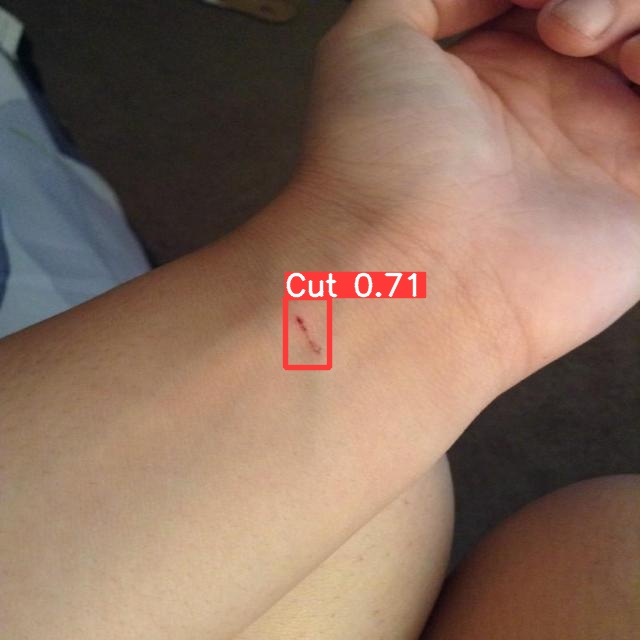

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:20]: #assuming JPG
    display(Image(filename=imageName))

## Deploy Model on Roboflow

Once you have finished training your YOLOv5 model, you’ll have a set of trained weights ready for use. These weights will be in the `/content/yolov5/runs/train/yolov5s_results/` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv5 weights.

**Before you run this code, make sure you create a new Version in the Roboflow dashboard following the instructions we covered earlier. Fill in your project name, workspace, and version number below.**

To upload model weights, add the following code to the “Inference with Custom Model” section in the aforementioned notebook:

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="BMWLxCMxFPAks4AmkTSD")
project = rf.workspace("jose-castillo").project("project-perfect-form")
version = project.version(2)
dataset = version.download("yolov5")

project.version(dataset.version).deploy(model_type="yolov5", model_path=f"/content/yolov5/runs/train/yolov5s_results/")

loading Roboflow workspace...
loading Roboflow project...
An error occured when getting the model upload URL: This version already has a trained model. Please generate and train a new version in order to upload model to Roboflow.


In [ ]:
%ls

sample_data/  temp.jpg  yolov5/


In [ ]:
#Run inference on your model on a persistant, auto-scaling, cloud API
from google.colab.patches import cv2_imshow

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

running inference on 74-3-_jpg.rf.9f7e364a24c2f1bb9f7336da80a01923.jpg


{'predictions': [{'x': 366.5,
   'y': 528.0,
   'width': 27.0,
   'height': 48.0,
   'confidence': 0.8380154371261597,
   'class': 'Barbell',
   'class_id': 0,
   'detection_id': '469d2ea5-c980-4b66-9249-7ed160da051c',
   'image_path': '/content/yolov5/Project-Perfect-form-2/test/images/74-3-_jpg.rf.9f7e364a24c2f1bb9f7336da80a01923.jpg',
   'prediction_type': 'ObjectDetectionModel'}],
 'image': {'width': '640', 'height': '640'}}

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""
iou_threshold = 0.5

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_threshold,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

_To use your YOLOv5 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv5. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._

## Webcam Usage

SOURCE: Colab Cam Sample Code https://pypi.org/project/colabcam/ and OpenCV


In [ ]:
!pip install colabcam

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 12.4 MB/s eta 0:00:00
  Created wheel for colabcam: filename=colabcam-1.0.3-py3-none-any.whl size=5487 sha256=9e217627554279fe97e7b5ffe807a5bd8ffc60810db9799e51688d3241811899
  Stored in directory: /root/.cache/pip/wheels/5a/ec/08/a87ee87cbf9c5d825e3433eb730e708d708e02158cd56f9606
Successfully built colabcam


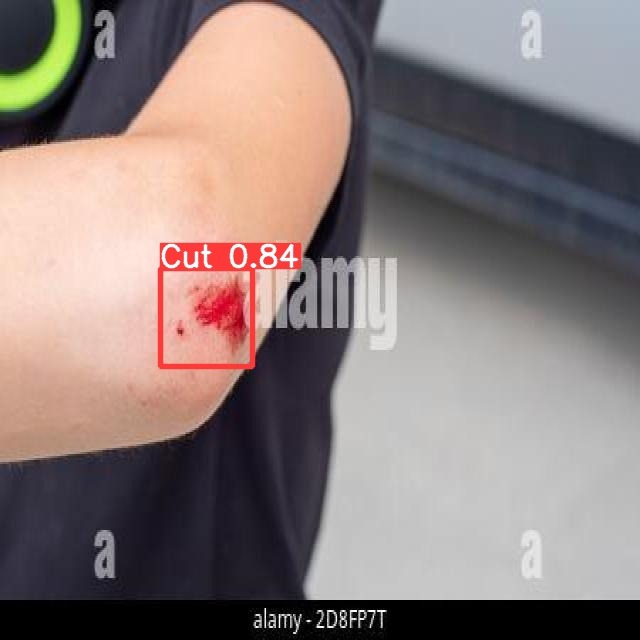

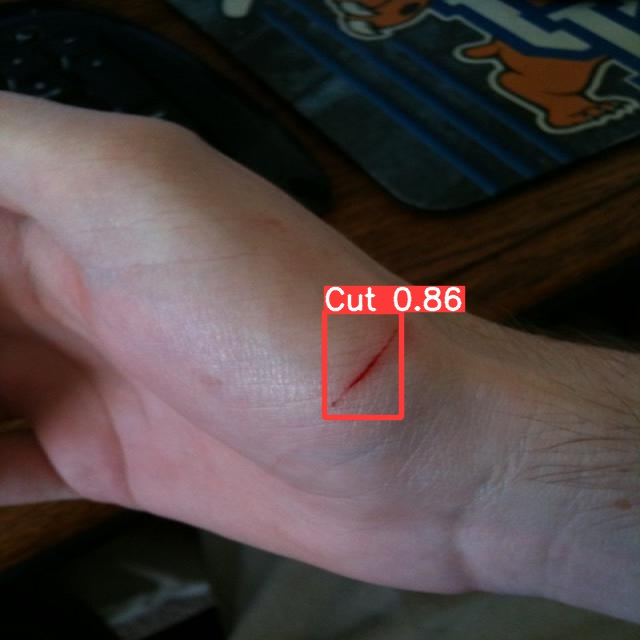

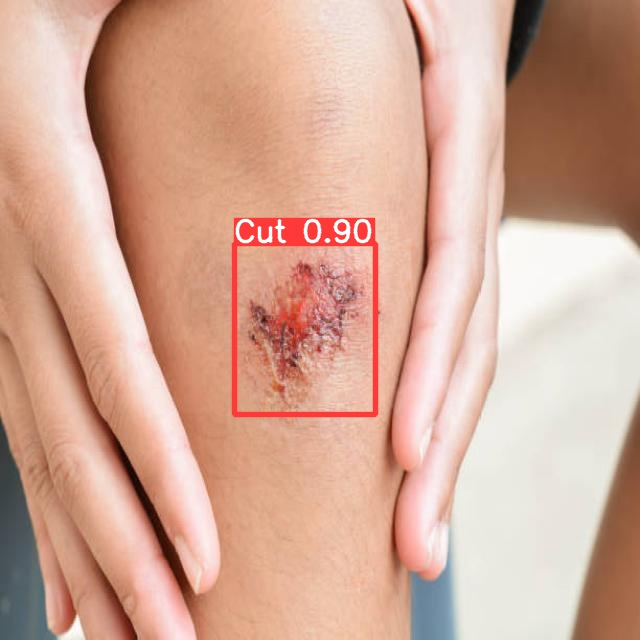

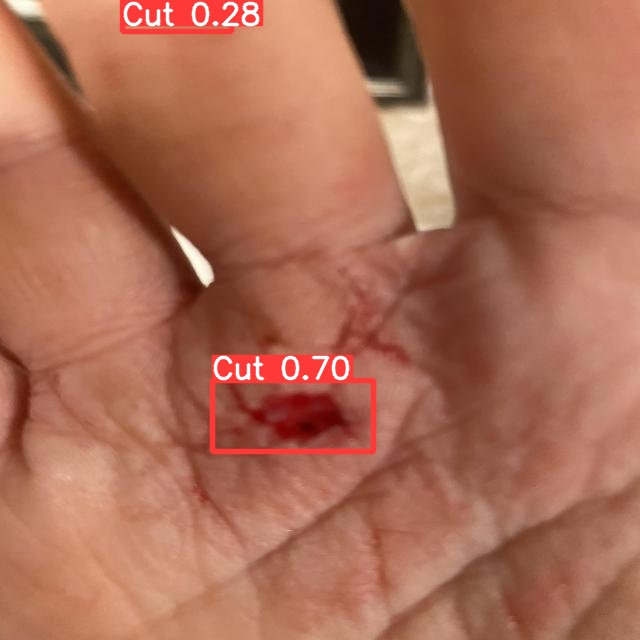

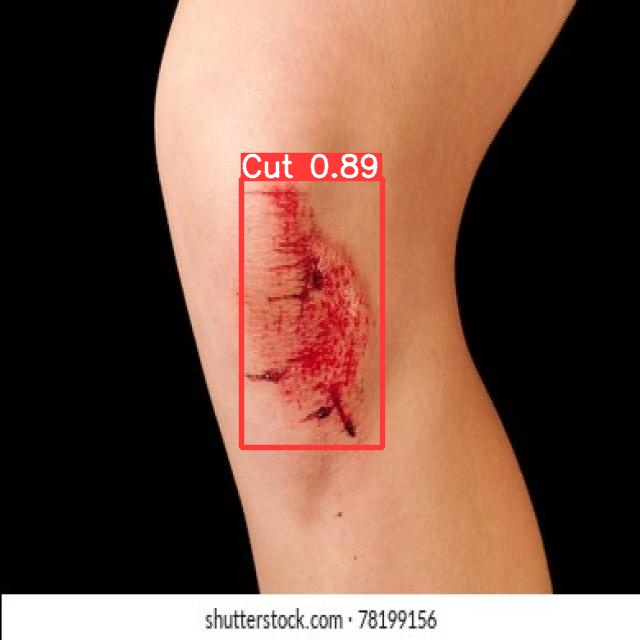

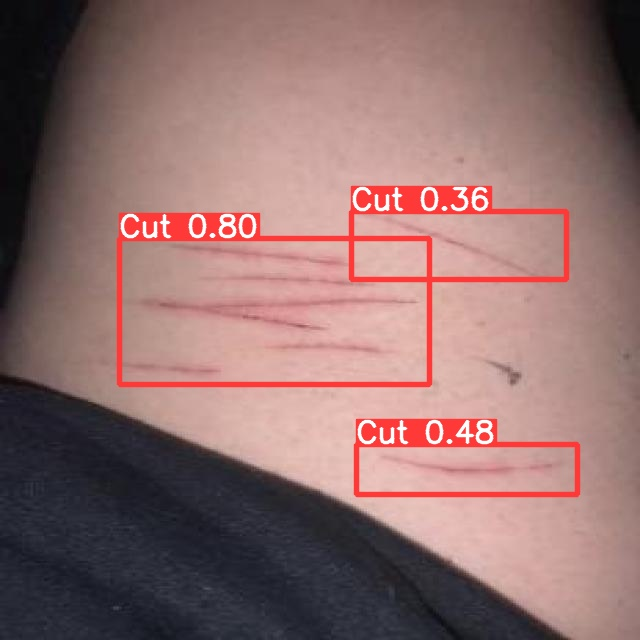

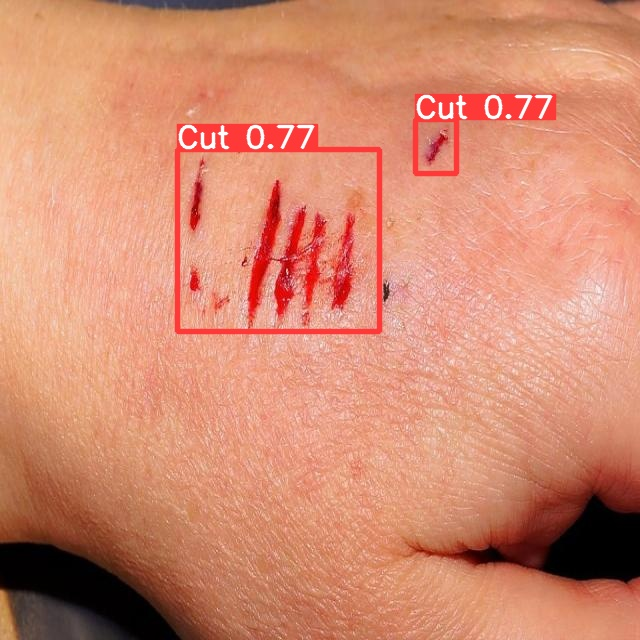

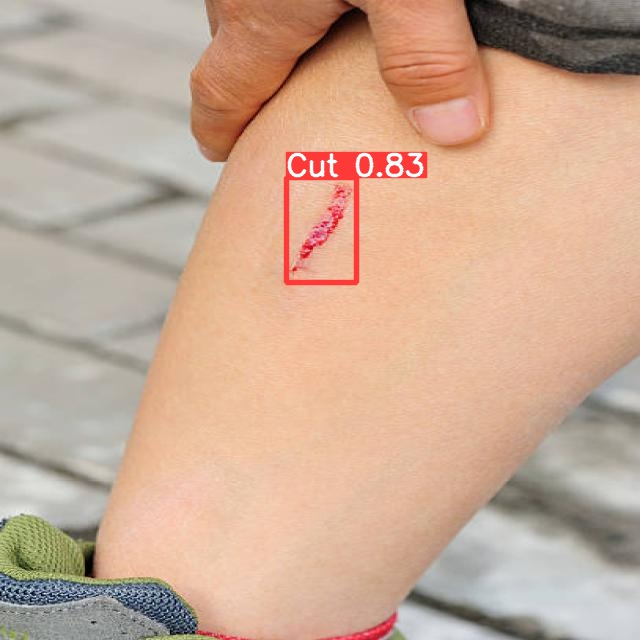

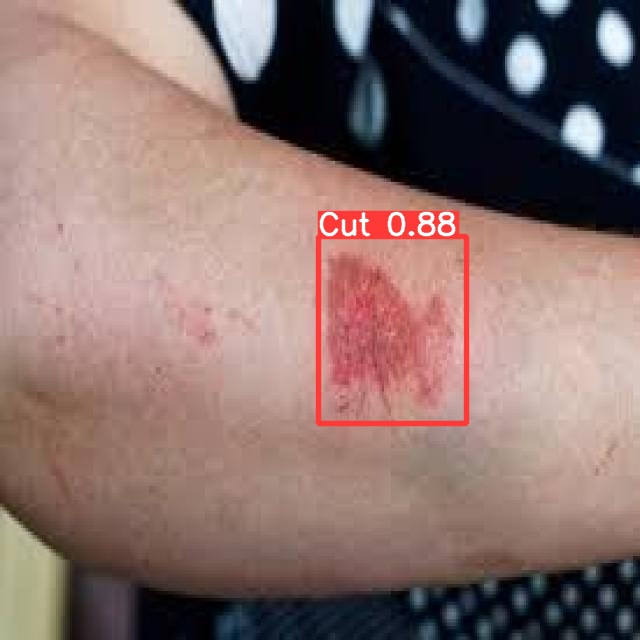

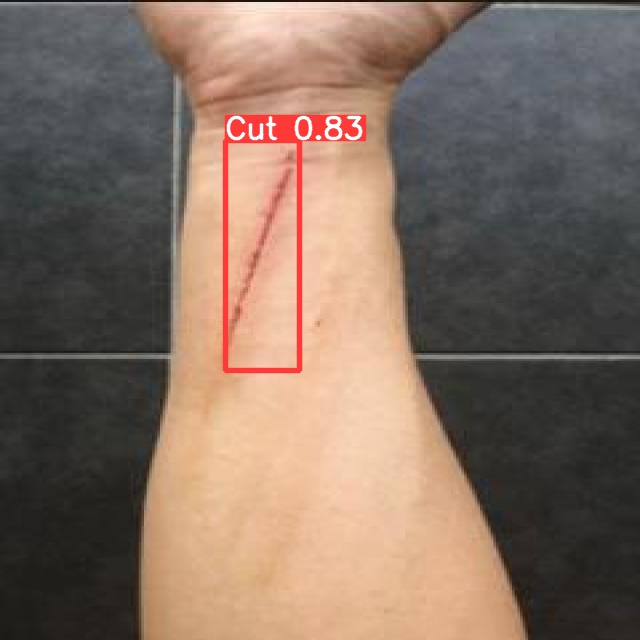

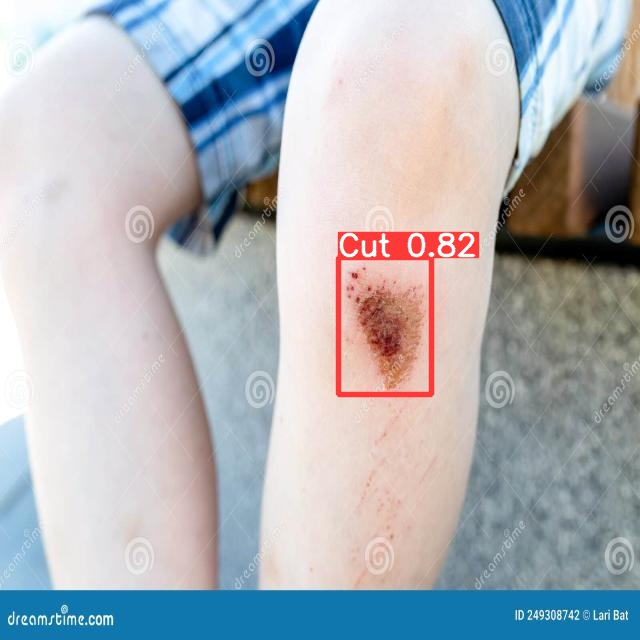

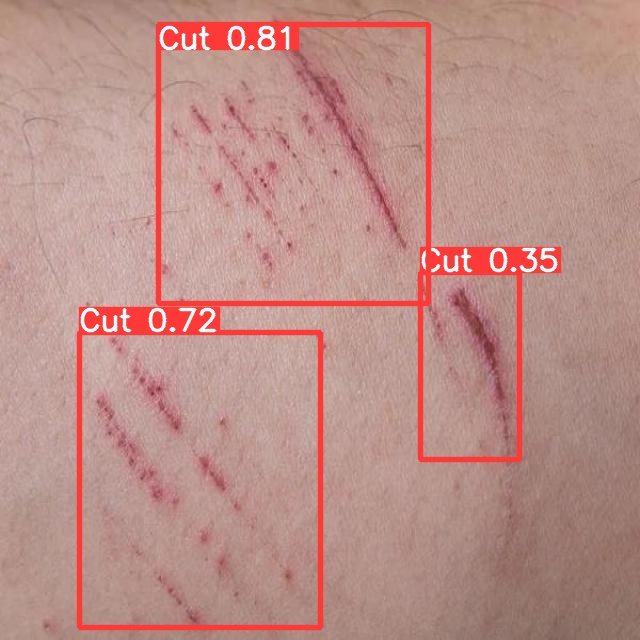

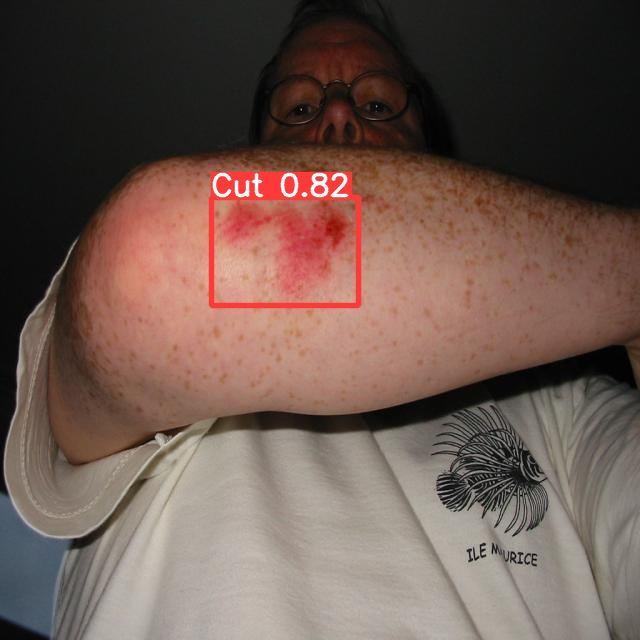

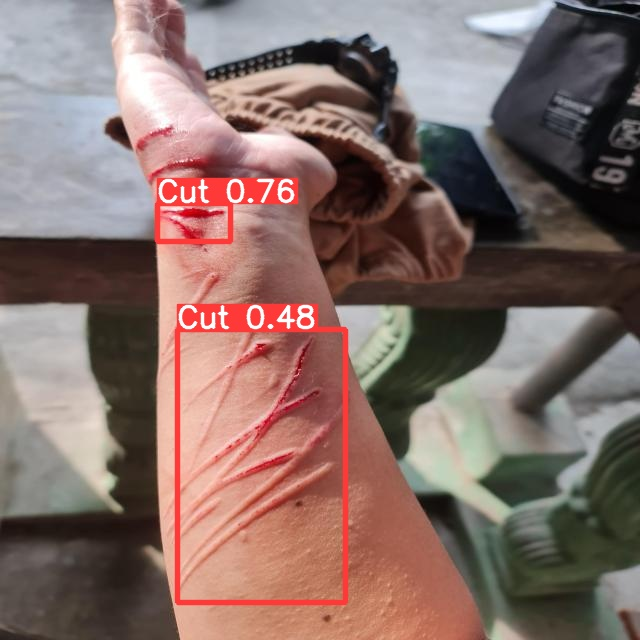

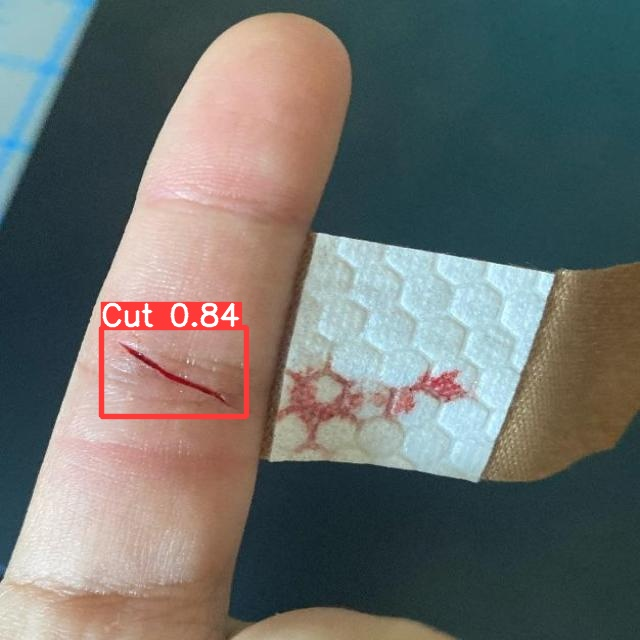

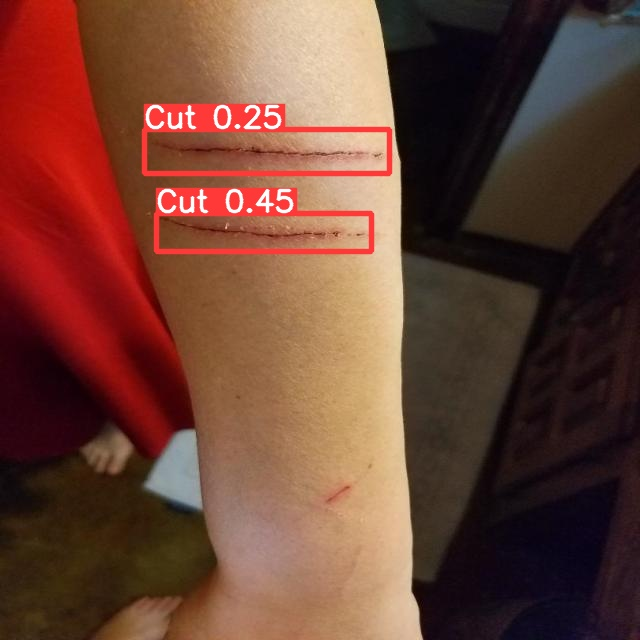

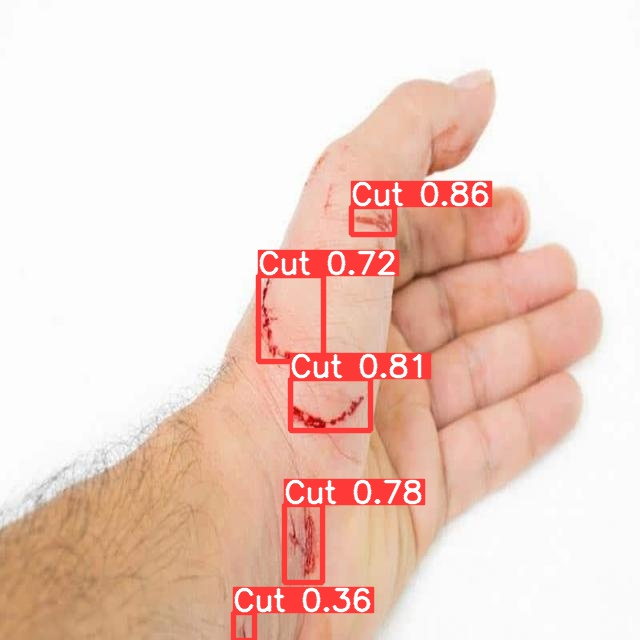

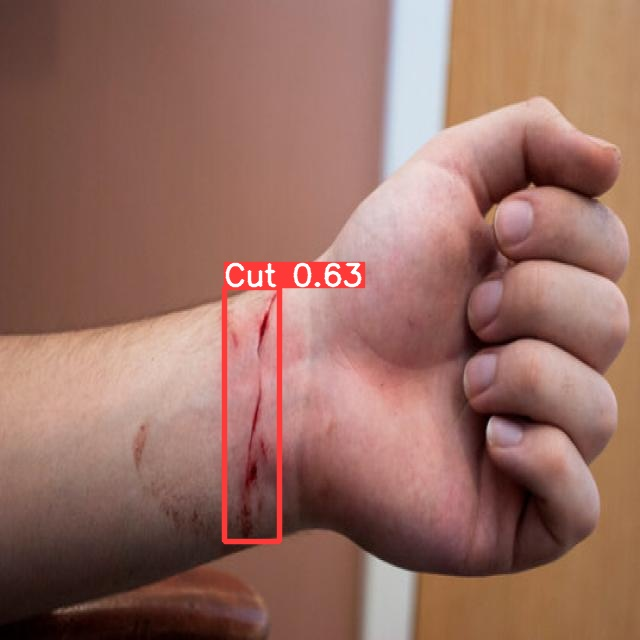

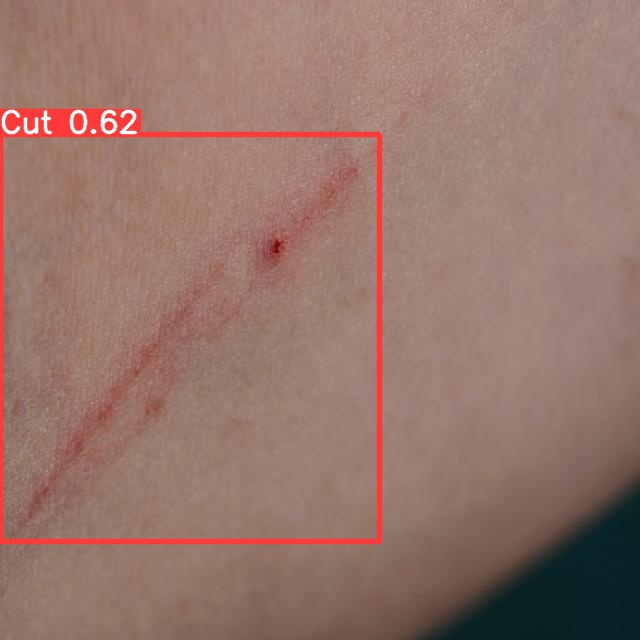

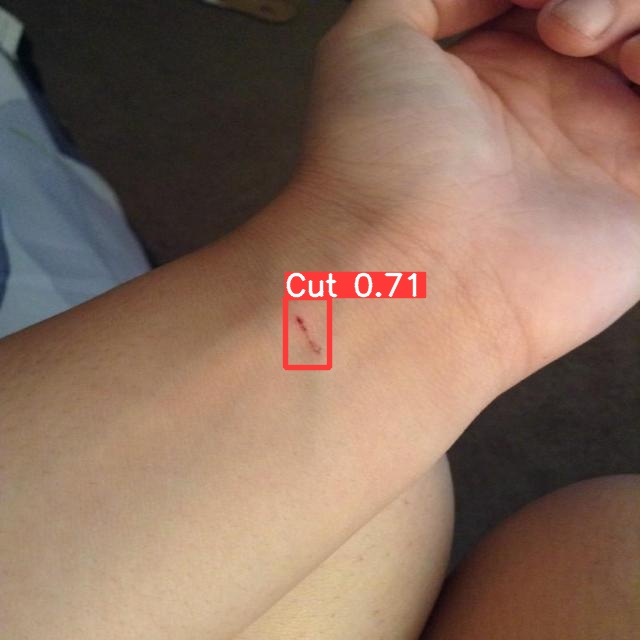

<IPython.core.display.Javascript object>

{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [{'x': 213.0, 'y': 283.5, 'width': 40.0, 'height': 27.0, 'confidence': 0.570622980594635, 'class': 'Barbell', 'class_id': 0, 'detection_id': 'b75e4066-c633-4951-a1e3-3961ef7af9c5', 'image_path': '/content/temp.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '640', 'height': '480'}}


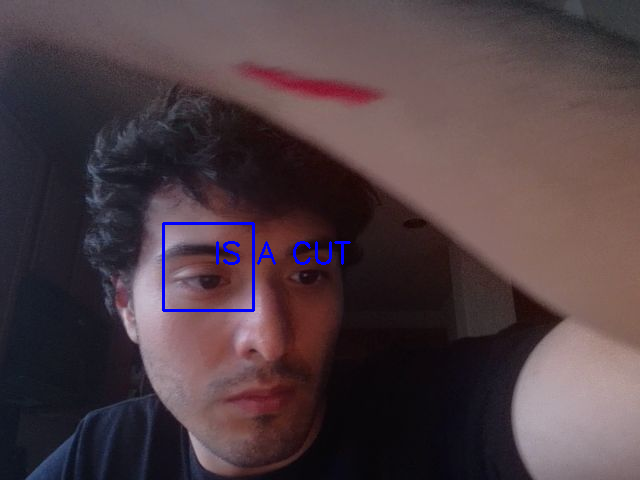

{'predictions': [{'x': 204.0, 'y': 58.0, 'width': 48.0, 'height': 34.0, 'confidence': 0.7150879502296448, 'class': 'Barbell', 'class_id': 0, 'detection_id': '6ceb8a7d-be01-46a0-b9c4-abb0dbc17f5f', 'image_path': '/content/temp.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 235.5, 'y': 276.5, 'width': 41.0, 'height': 27.0, 'confidence': 0.5224145650863647, 'class': 'Barbell', 'class_id': 0, 'detection_id': '0881220c-2d39-457d-89ea-e81d16763d36', 'image_path': '/content/temp.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '640', 'height': '480'}}


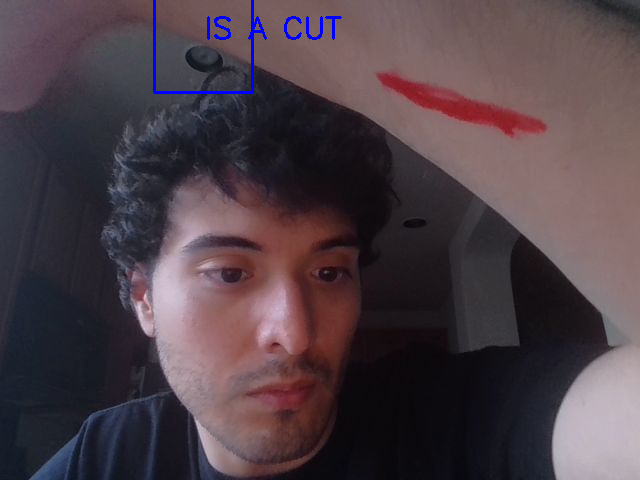

{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '

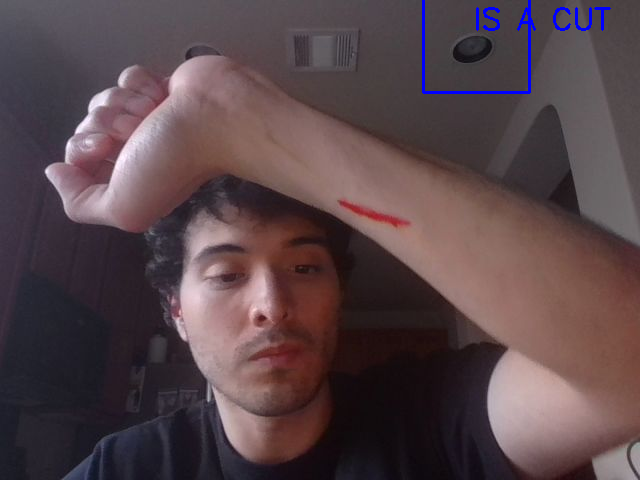

{'predictions': [{'x': 203.5, 'y': 57.5, 'width': 47.0, 'height': 35.0, 'confidence': 0.7017480134963989, 'class': 'Barbell', 'class_id': 0, 'detection_id': 'df04e78b-b48b-4915-be79-bc6275b8faf5', 'image_path': '/content/temp.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '640', 'height': '480'}}


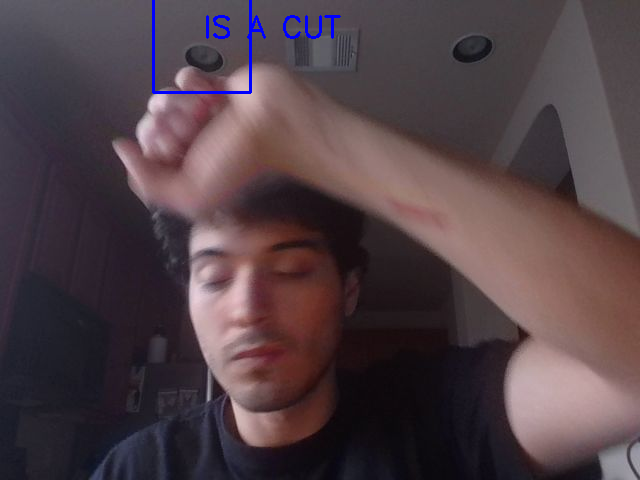

{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '

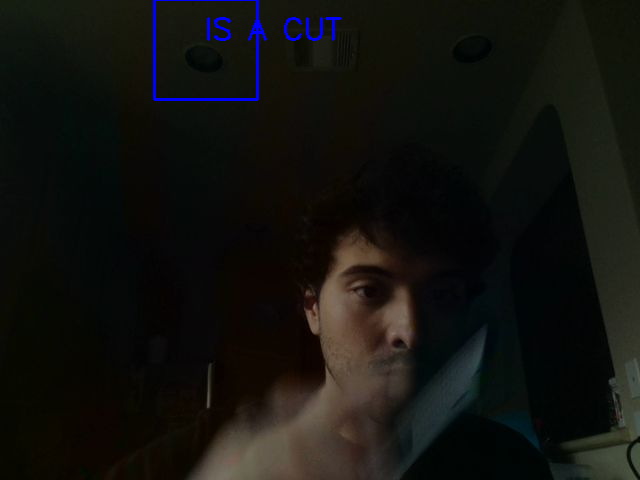

{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}
{'predictions': [], 'image': {'width': '640', 'height': '480'}}


In [ ]:
from google.colab.patches import cv2_imshow #
import colabcam
import numpy as np
import cv2
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

#import glob
#from IPython.display import Image, display
#for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:20]: #assuming JPG
#    display(Image(filename=imageName))

# start streaming video from webcam
colabcam.video_stream()
# label for video
label_html = 'Capturing'
# initialze bounding box to empty
bbox = ''
while True:
  js_reply = colabcam.video_frame(label_html, bbox)
  if not js_reply:break
  # convert JS response to OpenCV Image
  img = colabcam.js_to_image(js_reply["img"])


  #saves image into opencv format
  cv2.imwrite('/content/temp.jpg', img)

  ##uses the model to predict
  results = model.predict('/content/temp.jpg', confidence=40, overlap=30).json()
  print(results)

  if img is None:
    print("Error: Conversion to OpenCV image failed")
    break

  if len(results['predictions']) != 0:
    x = int(results["predictions"][0]['x'])
    y = int(results["predictions"][0]['y'])
    width = int(results["predictions"][0]['width'])
    height = int(results["predictions"][0]['height'])
    frameWidth = int(results['image']['width'])
    frameHeight = int(results['image']['height'])

    cv2.putText(img,'IS A CUT',(x,y-20),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
    cv2.rectangle(img, (x-50, y-60), (x + width, y + height), (255, 0, 0), 2)  # Blue color, thickness 2, OpenCV uses BGR.

    # Display the image
    cv2_imshow(img)

    me_width=np.shape(img)[0:2]
    overlapImg = np.zeros([frameHeight,frameWidth,4], dtype=np.uint8)

In [ ]:
import os

# Create a directory for captured images
output_directory = '/content/GOOGLEVIDEOCAPTUREIMAGES'
os.makedirs(output_directory, exist_ok=True)


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Use function to capture a photo and save it to the desired directory
filename = os.path.join(output_directory, 'captured_image.jpg')
take_photo(filename)


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
import os

# Define the output directory
output_directory = '/content/GOOGLEVIDEOCAPTUREIMAGES'

# Create the directory if it does not exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Directory created at {output_directory}")
else:
    print(f"Directory already exists at {output_directory}")


Directory already exists at /content/GOOGLEVIDEOCAPTUREIMAGES


In [ ]:
import os
import time
from IPython.display import Javascript, display
from google.colab.output import eval_js
from base64 import b64decode

# Ensure the output directory exists
output_directory = '/content/GOOGLEVIDEOCAPTUREIMAGES'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Directory created at {output_directory}")
else:
    print(f"Directory already exists at {output_directory}")

def take_photos(output_directory, num_photos=9, delay=1):
    js = Javascript('''
    async function takePhotos(numPhotos, delay) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Wait for the video to start playing
      await new Promise(resolve => setTimeout(resolve, 1000));

      for (let i = 0; i < numPhotos; i++) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        const data = canvas.toDataURL('image/jpeg', 0.8);
        google.colab.kernel.invokeFunction('notebook.SaveImage', [data, i], {});
        await new Promise(resolve => setTimeout(resolve, delay * 1000)); // delay between photos
      }

      stream.getVideoTracks()[0].stop();
      div.remove();
    }
    ''')
    display(js)
    for i in range(num_photos):
        data = eval_js('takePhotos({}, {})'.format(num_photos, delay))
        binary = b64decode(data.split(',')[1])
        filename = os.path.join(output_directory, f'captured_image_{i+1}.jpg')
        with open(filename, 'wb') as f:
            f.write(binary)
        print(f"Image {i+1} saved to {filename}")

# Capture images
take_photos(output_directory)

# Run the YOLOv5 detection on the captured images
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.25 --source /content/GOOGLEVIDEOCAPTUREIMAGES


Directory already exists at /content/GOOGLEVIDEOCAPTUREIMAGES


<IPython.core.display.Javascript object>

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.25 --source {GOOGLEVIDEOCAPTUREIMAGES}
--source Project-Pocket-Paramedic-1/test/images/


/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source={GOOGLEVIDEOCAPTUREIMAGES}, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 261, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 256, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **k

Directory already exists at /content/GOOGLEVIDEOCAPTUREIMAGES


<IPython.core.display.Javascript object>

Saved image 1 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_1.jpg
Saved image 2 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_2.jpg
Saved image 3 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_3.jpg
Saved image 4 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_4.jpg
Saved image 5 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_5.jpg
Saved image 6 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_6.jpg
Saved image 7 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_7.jpg
Saved image 8 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_8.jpg
Saved image 9 to /content/GOOGLEVIDEOCAPTUREIMAGES/image_9.jpg


In [1]:
from IPython.display import display, Javascript
from google.colab import output
from base64 import b64decode
import os

output_directory = '/content/GOOGLEVIDEOCAPTUREIMAGES'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Directory created at {output_directory}")
else:
    print(f"Directory already exists at {output_directory}")

def take_photos(output_directory, num_photos=9, delay=1):# HOW MANY IMAGES?
    js = '''
    async function takePhotos(numPhotos, delay) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      for (let i = 0; i < numPhotos; i++) {
        await new Promise(resolve => setTimeout(resolve, delay * 1000)); // delay between photos
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        const data = canvas.toDataURL('image/jpeg', 0.8).split(',')[1];
        google.colab.kernel.invokeFunction('notebook.save_image', [data, i], {});
      }
      stream.getVideoTracks()[0].stop();
      div.remove();
    }
    '''

    # Register a Python function to handle image data
    def save_image(data, index):
        image_path = f"{output_directory}/image_{index + 1}.jpg"
        with open(image_path, "wb") as f:
            f.write(b64decode(data))
            print(f"Saved image {index + 1} to {image_path}")

    output.register_callback('notebook.save_image', save_image)

    # Display and execute JavaScript
    display(Javascript(js))
    eval_js(f'takePhotos({num_photos}, {delay})')

take_photos(output_directory)

%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.25 --source /content/GOOGLEVIDEOCAPTUREIMAGES --project /content --name GOOGLE --exist-ok

from IPython.display import Image, display
import os

# Path where the detected images are saved
output_directory = '/content/GOOGLE'

# List all jpg images in the output directory
images = [os.path.join(output_directory, img) for img in os.listdir(output_directory) if img.endswith('.jpg')]

# Display images
for img_path in images:
    display(Image(filename=img_path))


Directory created at /content/GOOGLEVIDEOCAPTUREIMAGES


<IPython.core.display.Javascript object>

NameError: name 'eval_js' is not defined

In [ ]:
import shutil
import os

folder_path = '/content/GOOGLEVIDEOCAPTUREIMAGES/'
shutil.make_archive('/content/yolovFIX', 'zip', folder_path)
files.download('/content/yolovFIX.zip')

NameError: name 'files' is not defined

In [67]:
import shutil
from google.colab import files

# Define the directory to be zipped
folder_path = '/content/yolov5'

# Define the output filename for the zip file
zip_name = '/content/test12345'

# Create a zipped archive of your folder
shutil.make_archive(zip_name, 'zip', folder_path)

# Download the file to your local computer
files.download('/content/test12345.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>